In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

In [2]:
def normalize(x):
    mean = np.mean(x)
    std = np.std(x)
    x_norm = (x - mean) / std
    return x_norm

def standardize(x):
    m = max(x)
    return x/m

def replace_outliers_zscore(x, threshold=3):
    z = np.abs((x - np.mean(x)) / np.std(x))
    x_filtered = x.copy()
    x_filtered[z >= threshold] = np.median(x)
    return x_filtered

def average_window(signal, window_size, averaging_method=np.average):
    moving_averages = []
    for i in range(window_size, len(signal) + 1, window_size):
        window = signal[i-window_size:i]
        
        avg = averaging_method(window)
        
        moving_averages.append(avg)
    return np.array(moving_averages)

def split_dataframe(df, split_indexes):
    split_indexes = list(np.cumsum(split_indexes))
    split_indexes.append(len(df))
    
    dfs = []
    start = 0
    for end in split_indexes:
        dfs.append(df.iloc[start:end])
        start = end
    return dfs[:-1]

class Configuration:
    def __init__(self, root, scaling, dataRange):
        self.root = root
        self.raw = r"/".join([root, "raw"])
        self.processed = r"/".join([root, "processed"])
        self.scaling = scaling
        self.dr = dataRange
        self.csv_name = "Gabe_5min_walk1.csv"

config = Configuration(root=r"M:/Datasets/shock_walk", scaling=10000, dataRange= slice(0, -1))

### Old Solution

In [46]:
csv_list = [i for i in os.listdir(config.raw) if i.split(".")[-1] == "csv"]
csv_list = [csv_list[i] for i in [0, 6, 12, -2, -1]]
print(csv_list)

sad = input()
csv_lengths = []
new_csv = {}
for file in csv_list[0:]:
        
    file_path = r"/".join([config.raw, file])
    
    df = pd.read_csv(file_path)
    # EMGS = (df.iloc[config.dr, 1::8] * config.scaling)
    df.iloc[:, 1::8] = (df.iloc[:, 1::8] * config.scaling)
    df = df.iloc[:, 1::2]
    
    accel, emg = {}, {}
    
    for column in df.columns:
        if "EMG" in column:
            emg[column] = df[column].values
        if "Acc" in column:
            accel[column] = df[column].values
            
    emg = pd.DataFrame(emg)
    accel = pd.DataFrame(accel)
    accel = pd.concat((accel.iloc[:100, :], accel.iloc[100:, :].replace(0, float('nan')) ))
    accel = accel.dropna(how='all')
    accel = accel.fillna(0)
    
    
    used_df = None
    lengths = {}
    
    for i, column in enumerate(df.columns):
        
        window_size = None
        if "EMG" in column:
            window_size = 64
            used_df = emg
            
        if "Acc" in column:
            window_size = 4
            used_df = accel
        
        values = replace_outliers_zscore(used_df[column], threshold=3)
        
        values = values - np.mean(values)
        values = abs(values)
        values = average_window(values, window_size, np.median)
        
        
        if column in new_csv.keys():
            new_csv[column] = np.append(new_csv[column], values[:60 * 30])
        else:
            new_csv[column] = values[:60 * 30]
            
    print(r"/".join([config.processed, file]))
    
    # min_length = min(list(lengths.keys()))
    csv_lengths.append(1800)
    
for i, column in enumerate(new_csv.keys()):
    
    new_csv[column] = replace_outliers_zscore(new_csv[column], threshold=3)

    # new_csv[column] = normalize(new_csv[column])
    new_csv[column] = standardize(new_csv[column])
    
    
new_csv = pd.DataFrame(new_csv)
frames_per_video = [60 * 30] * len(csv_list)
splited_csv = split_dataframe(new_csv, frames_per_video)

for name, csv, frames in zip(csv_list, splited_csv, frames_per_video):
    csv = csv.iloc[:frames]
    print(len(csv))
    csv.to_csv(r"/".join([config.processed, name]), index=False)



# new_csv.to_csv(r"/".join([config.processed, "total.csv"]), index=False)

['2.0mph.csv', '2.5mph.csv', '3.1mph.csv', 'Quiet_Stance_0.csv', 'StandStop_2mph.csv']


M:/Datasets/shock_walk/processed/2.0mph.csv
M:/Datasets/shock_walk/processed/2.5mph.csv
M:/Datasets/shock_walk/processed/3.1mph.csv
M:/Datasets/shock_walk/processed/Quiet_Stance_0.csv
M:/Datasets/shock_walk/processed/StandStop_2mph.csv
1800
1800
1800
1800
1800


In [47]:
display(new_csv)

,L_Quad: EMG 1,L_Quad: Acc 1.X,L_Quad: Acc 1.Y,L_Quad: Acc 1.Z,L_Hamstrings: EMG 2,L_Hamstrings: Acc 2.X,L_Hamstrings: Acc 2.Y,L_Hamstrings: Acc 2.Z,L_AnteriorTibialis: EMG 3,L_AnteriorTibialis: Acc 3.X,...,R_Hamstrings: Acc 6.Y,R_Hamstrings: Acc 6.Z,R_AnteriorTibialis: EMG 7,R_AnteriorTibialis: Acc 7.X,R_AnteriorTibialis: Acc 7.Y,R_AnteriorTibialis: Acc 7.Z,R_Calf: EMG 8,R_Calf: Acc 8.X,R_Calf: Acc 8.Y,R_Calf: Acc 8.Z
0,0.121022,0.121347,0.022321,0.307524,0.001927,0.353142,0.005392,0.351515,0.013322,0.204471,...,0.027012,0.359168,0.335682,0.183103,0.030890,0.320502,0.565306,0.081148,0.623479,0.002051
1,0.121022,0.121347,0.022321,0.307524,0.001927,0.353142,0.005392,0.351515,0.013322,0.204471,...,0.027012,0.359168,0.335682,0.183103,0.030890,0.320502,0.565306,0.081148,0.623479,0.002051
2,0.121022,0.121347,0.022321,0.307524,0.001927,0.353142,0.005392,0.351515,0.013322,0.204471,...,0.027012,0.359168,0.335682,0.183103,0.030890,0.320502,0.565306,0.081148,0.623479,0.002051
3,0.043661,0.530109,0.071111,0.570102,0.467410,0.648173,0.189561,0.205117,0.565517,0.337582,...,0.027012,0.263872,0.332067,0.321027,0.072502,0.645408,0.398401,0.445979,0.366560,0.448273
4,0.302840,0.849457,0.261210,0.616488,0.308581,0.921115,0.282461,0.202301,0.475862,0.478453,...,0.118782,0.116743,0.179808,0.428737,0.081734,0.947223,0.344656,0.977589,0.118522,0.844151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.026666,0.247999,0.363427,0.050313,0.174711,0.214773,0.291363,0.953571,0.272414,0.585917,...,0.253618,0.618842,0.265991,0.255783,0.084931,0.291615,0.707085,0.555239,0.057011,0.829324
8996,0.254222,0.794104,0.430649,0.157954,0.467640,0.072780,0.370698,0.795789,0.487600,0.773005,...,0.045824,0.183592,0.647481,0.276556,0.176438,0.349339,0.748263,0.831449,0.081281,0.912085
8997,0.002628,0.849457,0.133427,0.162847,0.360538,0.156398,0.179030,0.888880,0.277918,0.899114,...,0.013110,0.199299,0.339077,0.414409,0.112624,0.324600,0.354962,0.659437,0.026961,0.918950
8998,0.589946,0.923357,0.128982,0.193834,0.256625,0.624770,0.274892,0.221906,0.650332,0.764409,...,0.065612,0.213435,0.232604,0.518270,0.214930,0.359235,0.204730,0.619098,0.106656,0.948698


In [48]:
# splited_csv = split_dataframe(new_csv, csv_lengths)
print(csv_lengths)
display(splited_csv[3])

[1800, 1800, 1800, 1800, 1800]


,L_Quad: EMG 1,L_Quad: Acc 1.X,L_Quad: Acc 1.Y,L_Quad: Acc 1.Z,L_Hamstrings: EMG 2,L_Hamstrings: Acc 2.X,L_Hamstrings: Acc 2.Y,L_Hamstrings: Acc 2.Z,L_AnteriorTibialis: EMG 3,L_AnteriorTibialis: Acc 3.X,...,R_Hamstrings: Acc 6.Y,R_Hamstrings: Acc 6.Z,R_AnteriorTibialis: EMG 7,R_AnteriorTibialis: Acc 7.X,R_AnteriorTibialis: Acc 7.Y,R_AnteriorTibialis: Acc 7.Z,R_Calf: EMG 8,R_Calf: Acc 8.X,R_Calf: Acc 8.Y,R_Calf: Acc 8.Z
5400,0.000589,0.866962,0.000565,0.000573,0.004651,0.000276,0.000729,0.000266,0.001267,0.000011,...,0.002283,0.000950,0.268690,0.000114,0.001996,0.000150,0.532246,0.909245,0.000664,0.000767
5401,0.000589,0.866962,0.000565,0.000573,0.004651,0.000276,0.000729,0.000266,0.001267,0.000011,...,0.002283,0.000950,0.268690,0.000114,0.001996,0.000150,0.532246,0.909245,0.000664,0.000767
5402,0.000589,0.866962,0.000565,0.000573,0.004651,0.000276,0.000729,0.000266,0.001267,0.000011,...,0.002283,0.000950,0.268690,0.000114,0.001996,0.000150,0.532246,0.909245,0.000664,0.000767
5403,0.005969,0.437390,0.000565,0.001971,0.035119,0.002542,0.003557,0.003443,0.047570,0.000781,...,0.002640,0.001265,0.105106,0.002396,0.001996,0.002657,0.074345,0.459526,0.001942,0.002765
5404,0.005380,0.002673,0.004476,0.003369,0.025817,0.006079,0.012041,0.007893,0.092606,0.002333,...,0.005639,0.002214,0.132794,0.003917,0.001996,0.005164,0.077768,0.009807,0.000664,0.004764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,0.004790,0.009534,0.003910,0.001887,0.049510,0.007268,0.004928,0.003443,0.045036,0.005460,...,0.008279,0.013605,0.069221,0.005972,0.007668,0.003836,0.116652,0.002832,0.001942,0.006608
7196,0.006808,0.008677,0.003910,0.003201,0.034276,0.007903,0.004928,0.000901,0.069455,0.005460,...,0.002640,0.011074,0.124599,0.005972,0.003674,0.003836,0.127852,0.001027,0.000664,0.004764
7197,0.004790,0.007819,0.000565,0.001887,0.041050,0.004725,0.005657,0.003443,0.068188,0.007804,...,0.002998,0.009808,0.103832,0.002169,0.005671,0.003836,0.105452,0.000903,0.003220,0.006608
7198,0.005969,0.006961,0.002804,0.000573,0.041050,0.001547,0.006385,0.002172,0.093873,0.008586,...,0.002998,0.011706,0.103832,0.006733,0.003674,0.000815,0.143405,0.008249,0.000664,0.006608


(9000,)
9000


[]

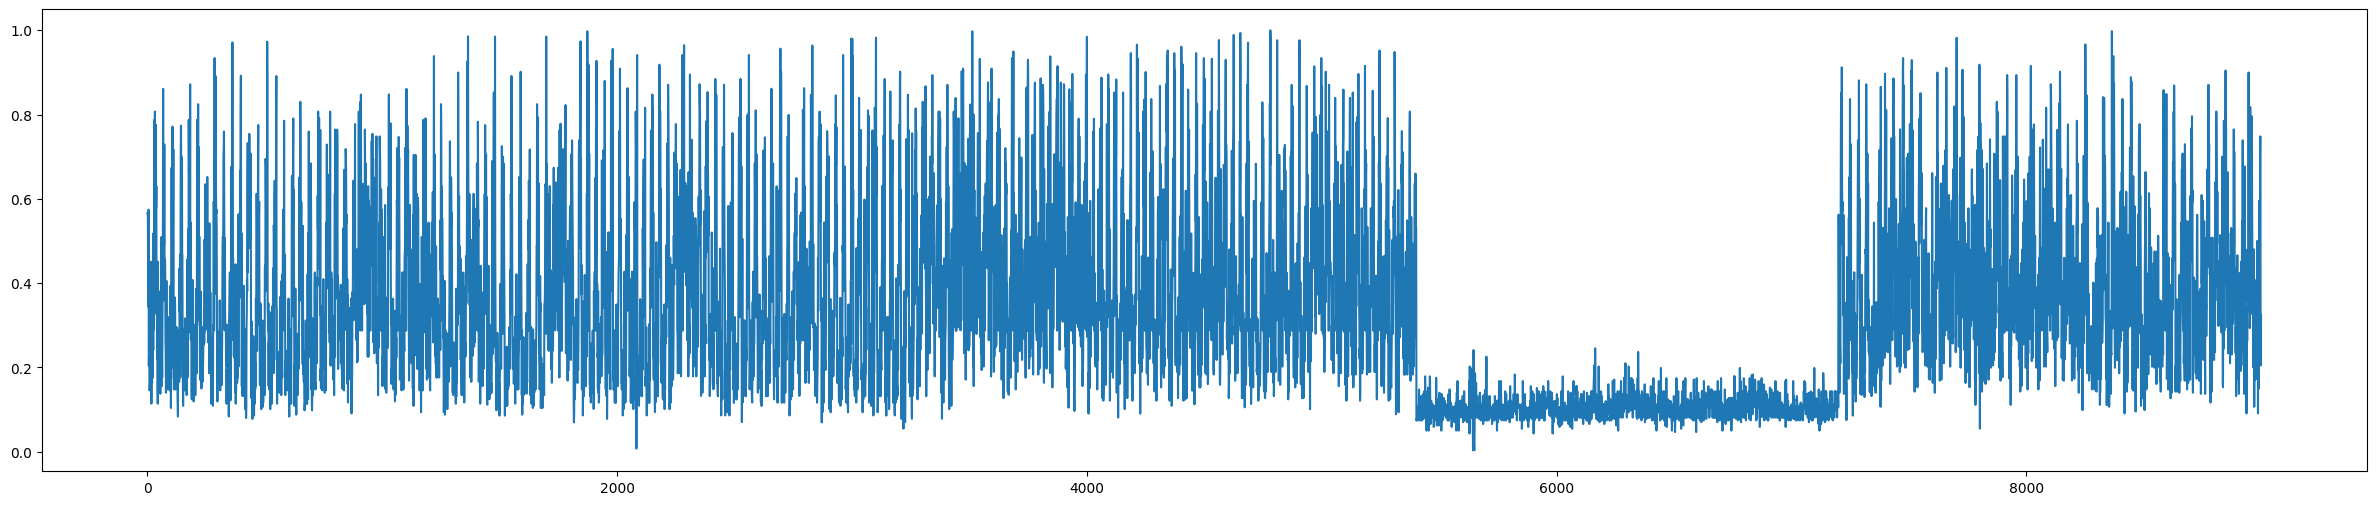

In [57]:
plt.figure(figsize=(30, 6), dpi=100)

plot_csv = new_csv.iloc[1800 * 0:, 0::4].iloc[:, 7]
print(plot_csv.shape)
print(len(plot_csv))

plt.plot(plot_csv.values)
plt.plot()
# plt.legend(plot_csv.columns)

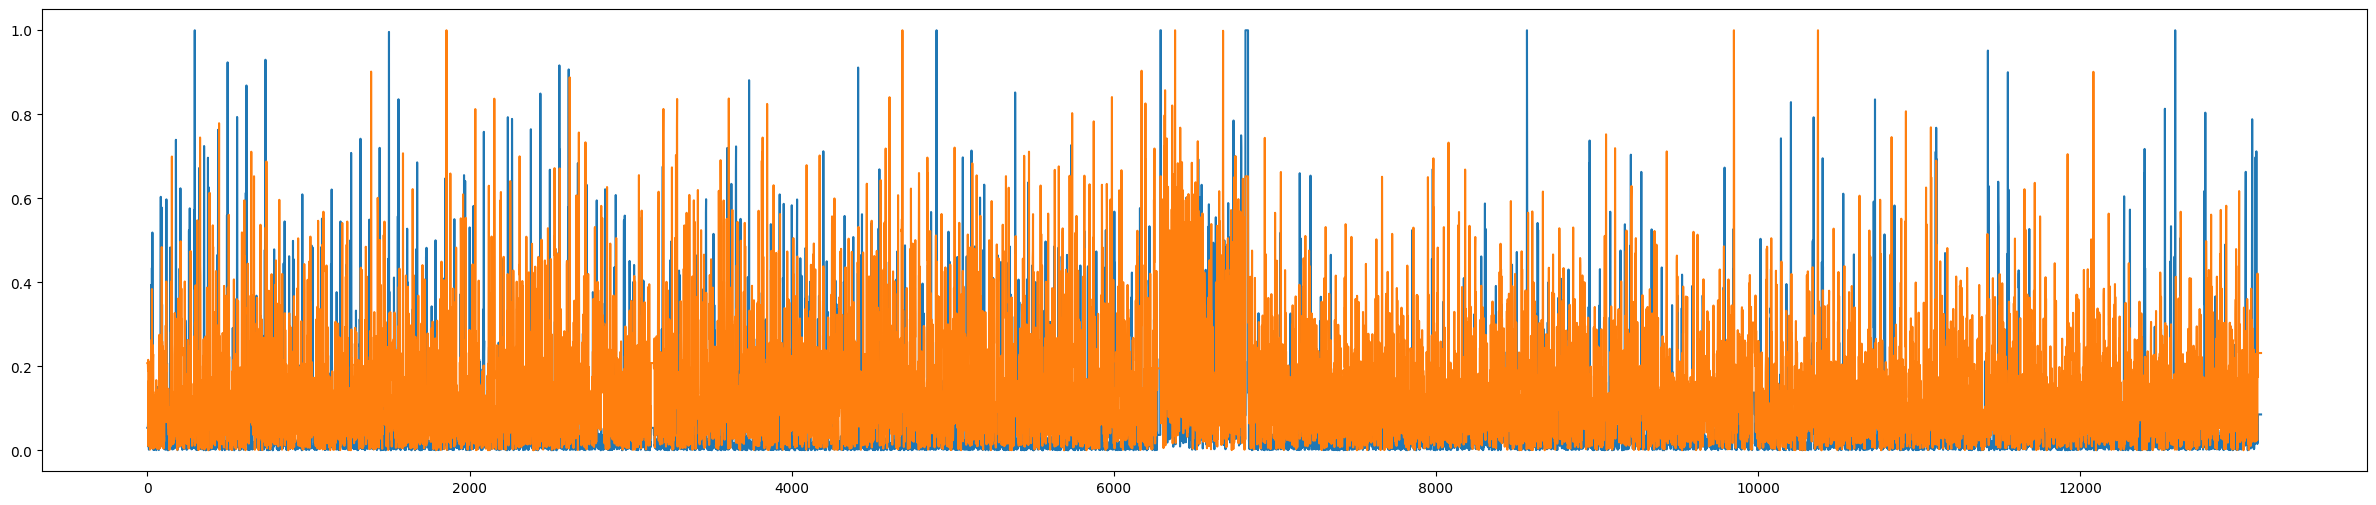

In [28]:
plt.figure(figsize=(30, 6), dpi=100)
plt.plot(new_csv[list(new_csv.keys())[0]])
plt.plot(new_csv[list(new_csv.keys())[4]])

In [ ]:
plt.figure(figsize=(30, 6), dpi=100)
plt.plot(new_csv[list(new_csv.keys())[1]])
plt.plot(new_csv[list(new_csv.keys())[5]])

In [ ]:
plt.figure(figsize=(30, 6), dpi=100)
plt.plot(new_csv[list(new_csv.keys())[2]])
plt.plot(new_csv[list(new_csv.keys())[6]])

In [ ]:
plt.figure(figsize=(30, 6), dpi=100)
plt.plot(new_csv[list(new_csv.keys())[3]])
plt.plot(new_csv[list(new_csv.keys())[7]])

In [19]:
[60 * 30] * 5

[1800, 1800, 1800, 1800, 1800]